In [13]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

class FlexibleDecoder(nn.Module):
    def __init__(self, latent_dim=2, data_dim=2, hidden_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.data_dim = data_dim
        
        # Flexible decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # Output means and log_stds for each dimension
            nn.Linear(hidden_dim, data_dim * 2)
        )
        
        # Prior parameters (can be learned)
        self.prior_mean = nn.Parameter(torch.zeros(latent_dim))
        self.prior_log_std = nn.Parameter(torch.zeros(latent_dim))
    
    def decode(self, z):
        """Decode latent vectors to distribution parameters"""
        outputs = self.decoder(z)
        mean, log_std = outputs.chunk(2, dim=-1)
        return mean, log_std
    
    def prior_log_prob(self, z, freeze_model=False):
        """Compute log probability under the prior"""
        if freeze_model:
            with torch.no_grad():
                prior = Normal(self.prior_mean, torch.exp(self.prior_log_std))
        else:
            prior = Normal(self.prior_mean, torch.exp(self.prior_log_std))
        return prior.log_prob(z).mean(-1)
    
    def reconstruction_log_prob(self, x, z, freeze_model=False):
        """Compute log probability of x under the decoder distribution"""
        if freeze_model:
            with torch.no_grad():
                mean, log_std = self.decode(z)
        else:
            mean, log_std = self.decode(z)
        dist = Normal(mean, torch.exp(log_std))
        return dist.log_prob(x).mean(-1)

    def reconstruction_loss(self, x, z, freeze_model=False):
        """Compute reconstruction loss using MSE
        
        Note: Using MSE loss instead of log probability is generally not recommended here
        because this is part of a probabilistic model that relies on proper log probabilities
        for inference. The log probability formulation allows proper uncertainty estimation
        and follows the mathematical principles of the model.
        """
        if freeze_model:
            with torch.no_grad():
                mean, log_std = self.decode(z)
        else:
            mean, log_std = self.decode(z)
        # MSE loss
        return torch.mean((x - mean) ** 2, dim=-1)
    
    def infer_latent(self, x, n_steps=50, learning_rate=0.1):
        """Gradient-based inference of latent variables"""
        batch_size = x.shape[0]
        
        # Initialize latents from prior
        z = torch.randn(batch_size, self.latent_dim, requires_grad=True)
        optimizer = torch.optim.Adam([z], lr=learning_rate)
        
        for step in range(n_steps):
            optimizer.zero_grad()
            
            # Compute ELBO: reconstruction - KL
            recon_log_prob = self.reconstruction_log_prob(x, z, freeze_model=True)
            prior_log_prob = self.prior_log_prob(z, freeze_model=True)
            
            # Negative ELBO (we minimize)
            loss = -(recon_log_prob + prior_log_prob).mean()
            
            loss.backward()
            optimizer.step()
        
        return z.detach()
    
    def sample(self, n_samples):
        """Generate samples from the model

        Mathematical Formulation (latex):
        z = N(\text{prior\_mean}, \text{prior\_std})
        x = N(\text{decode}(z), 1)
        """
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim) * torch.exp(self.prior_log_std) + self.prior_mean
            mean, log_std = self.decode(z)
            # Sample from the decoded distribution
            noise = torch.randn_like(mean) * torch.exp(log_std)
            return mean + noise
    
    def reconstruct(self, x):
        """Reconstruct data from the model

        Mathematical Formulation (latex):
        z = \text{infer\_latent}(x)
        x = N(\text{decode}(z), 1)

        Make sure to use no_grad, and add noise to the mean.
        """
        z = self.infer_latent(x)
        mean, log_std = self.decode(z)
        # Add noise according to the mathematical formulation
        noise = torch.randn_like(mean) * torch.exp(log_std)
        return mean + noise

# Generate Swiss roll data
n_samples = 1000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)
X = X[:, [0, 2]]  # Take only 2D projection
X = torch.FloatTensor(X)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Create and train model
model = FlexibleDecoder(latent_dim=2, data_dim=2, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [14]:
# Training loop
n_epochs = 3000 # 600
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Infer latents
    model.eval()
    z = model.infer_latent(X)
    model.train()
    
    # Compute loss
    recon_loss = model.reconstruction_loss(X, z)
    prior_log_prob = model.prior_log_prob(z)
    loss = (recon_loss - prior_log_prob).mean()

    # Alternative loss formulation:
    # recon_log_prob = model.reconstruction_log_prob(X, z)
    # prior_log_prob = model.prior_log_prob(z)
    # loss = -(recon_log_prob + prior_log_prob).mean()
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')



Epoch 200/3000, Loss: 1.7206
Epoch 400/3000, Loss: 1.5222
Epoch 600/3000, Loss: 1.3229
Epoch 800/3000, Loss: 1.1257
Epoch 1000/3000, Loss: 0.9305
Epoch 1200/3000, Loss: 0.7365
Epoch 1400/3000, Loss: 0.5451
Epoch 1600/3000, Loss: 0.3573
Epoch 1800/3000, Loss: 0.1815
Epoch 2000/3000, Loss: 0.0108
Epoch 2200/3000, Loss: -0.1376
Epoch 2400/3000, Loss: -0.2866
Epoch 2600/3000, Loss: -0.3907
Epoch 2800/3000, Loss: -0.4785
Epoch 3000/3000, Loss: -0.5367


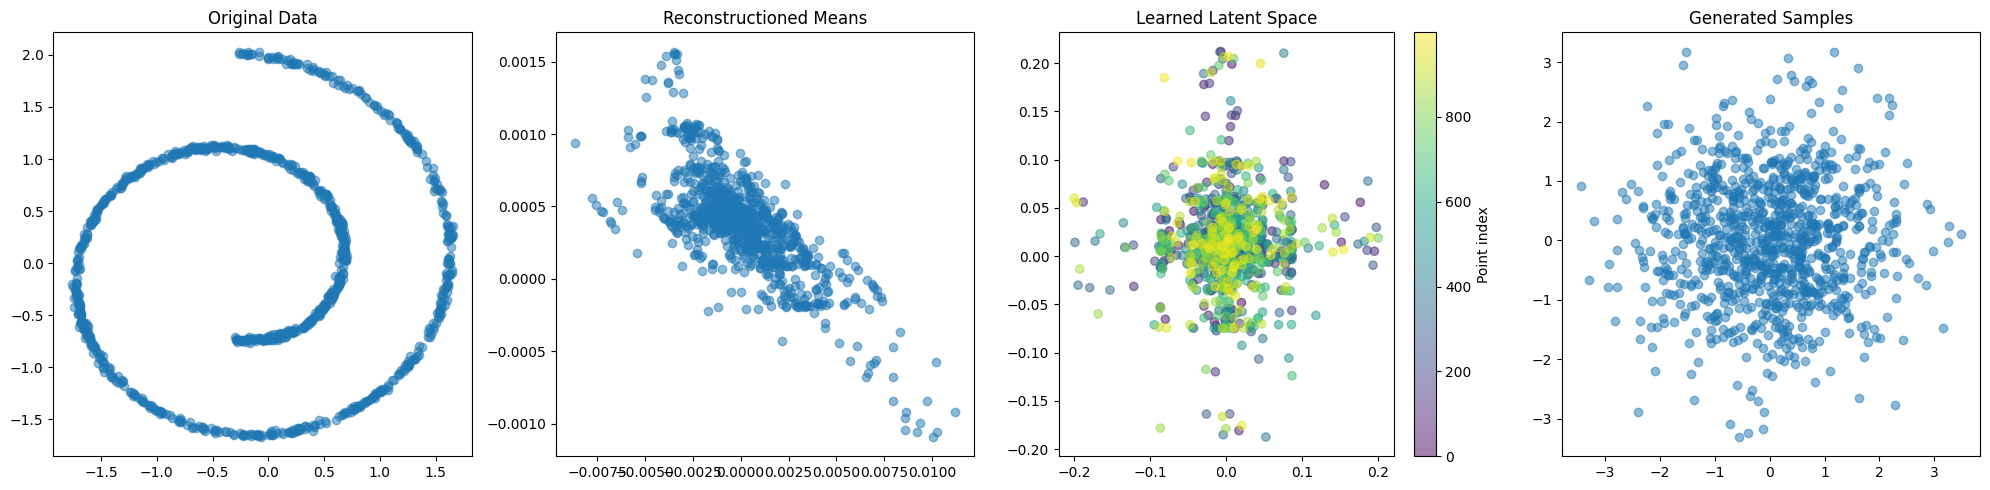

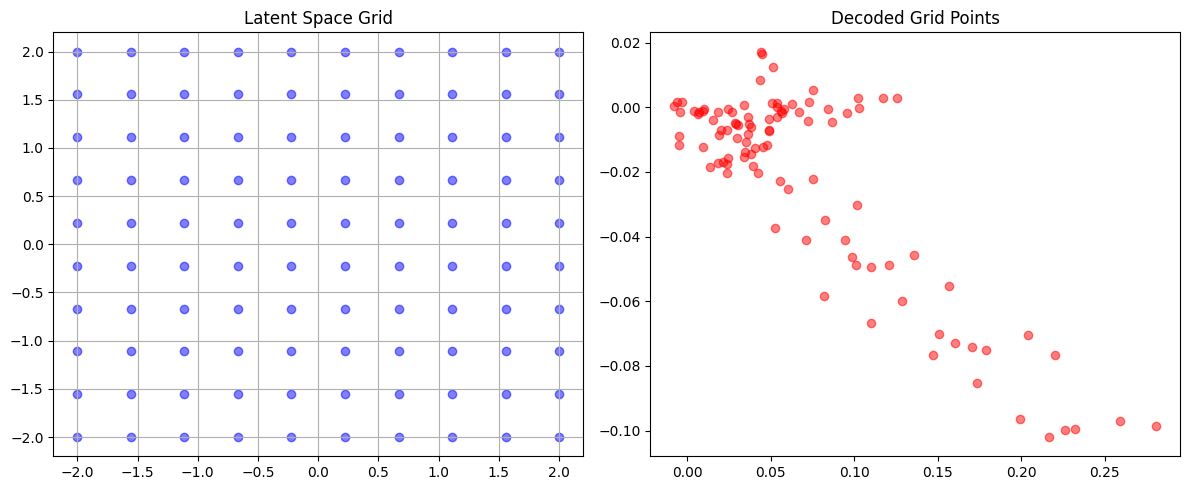

In [15]:
def visualize_model(X, model):
    plt.figure(figsize=(20, 5))
    
    # Plot original data
    plt.subplot(141)
    plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), alpha=0.5)
    plt.title('Original Data')
    
    # Plot reconstructions
    plt.subplot(142)
    z = model.infer_latent(X)
    mean, _ = model.decode(z)
    plt.scatter(mean[:, 0].detach().numpy(), 
                mean[:, 1].detach().numpy(), 
                alpha=0.5)
    plt.title('Reconstructioned Means')
    
    # Plot latent space
    plt.subplot(143)
    plt.scatter(z[:, 0].numpy(), z[:, 1].numpy(), 
                c=np.arange(len(z)), cmap='viridis', alpha=0.5)
    plt.colorbar(label='Point index')
    plt.title('Learned Latent Space')
    
    # Plot generated samples
    plt.subplot(144)
    samples = model.sample(n_samples=1000)
    plt.scatter(samples[:, 0].detach().numpy(), 
                samples[:, 1].detach().numpy(), 
                alpha=0.5)
    plt.title('Generated Samples')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_model(X, model)

# Demonstrate latent space interpolation
def interpolate_latent_space(model, n_points=10):
    # Create a grid in latent space
    x = np.linspace(-2, 2, n_points)
    y = np.linspace(-2, 2, n_points)
    xx, yy = np.meshgrid(x, y)
    
    # Convert to latent vectors
    z = torch.FloatTensor(np.stack([xx.ravel(), yy.ravel()], axis=1))
    
    # Decode
    with torch.no_grad():
        mean, _ = model.decode(z)
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Plot latent grid
    plt.subplot(121)
    plt.scatter(z[:, 0], z[:, 1], c='blue', alpha=0.5)
    plt.title('Latent Space Grid')
    plt.grid(True)
    
    # Plot decoded points
    plt.subplot(122)
    plt.scatter(mean[:, 0], mean[:, 1], c='red', alpha=0.5)
    plt.title('Decoded Grid Points')
    
    plt.tight_layout()
    plt.show()

# Show latent space interpolation
interpolate_latent_space(model)

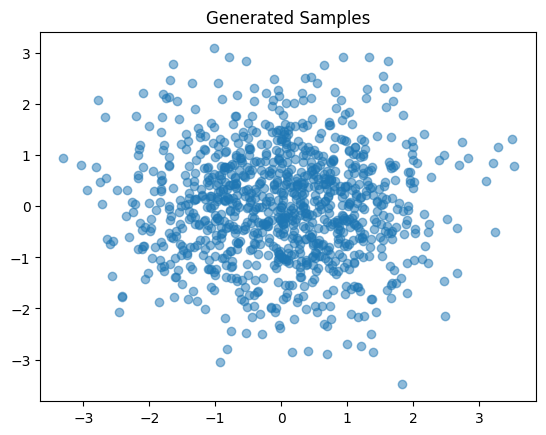

In [16]:
with torch.no_grad():
    samples = model.sample(n_samples=1000)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title('Generated Samples')
    plt.show()


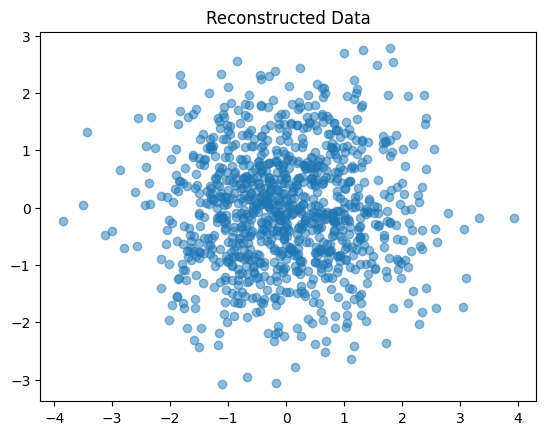

In [17]:
# reconstructed_X = model.reconstruct(X)
z = model.infer_latent(X)
mean, log_std = model.decode(z)
# Add noise according to the mathematical formulation
noise = torch.randn_like(mean) * torch.exp(log_std)
reconstructed_X = (mean + noise).detach().numpy()
plt.scatter(reconstructed_X[:, 0], reconstructed_X[:, 1], alpha=0.5)
plt.title('Reconstructed Data')
plt.show()
